<a href="https://colab.research.google.com/github/Sahanave/AICamp-Demo/blob/main/offline_preprocessing_and_embedding_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>Retriving detected objects using Gemma</h1></center>
<center><img src="https://res.infoq.com/news/2024/02/google-gemma-open-model/en/headerimage/generatedHeaderImage-1708977571481.jpg" width="400"></center>


# Introduction

Aging parents often struggle with memory, making it hard to find everyday items, which can feel overwhelming. To address this, we propose an assistive AI-powered application leveraging Gemma models and video data to answer queries like "Where did I last see my pen?". The system processes video frames, generates embeddings, and stores them in ChromaDB alongside metadata for efficient retrieval. With a simple, user-friendly interface, users can locate items quickly and independently. Designed for elderly individuals and their families, this solution fosters autonomy, eases caregiving challenges, and offers peace of mind to loved ones living abroad.

\# Using PaliGemma with 🤗 transformers

PaliGemma is a new vision language model released by Google. In this notebook, we will see how to use 🤗 transformers for PaliGemma inference.
First, install below libraries with update flag as we need to use the latest version of 🤗 transformers along with others.

Reference from  
1. Paligemma Colab : https://g.co/kgs/nrKLwTc
2. Chroma db cookbook : https://github.com/google-gemini/gemma-cookbook/blob/main/Gemma/RAG_with_ChromaDB.ipynb

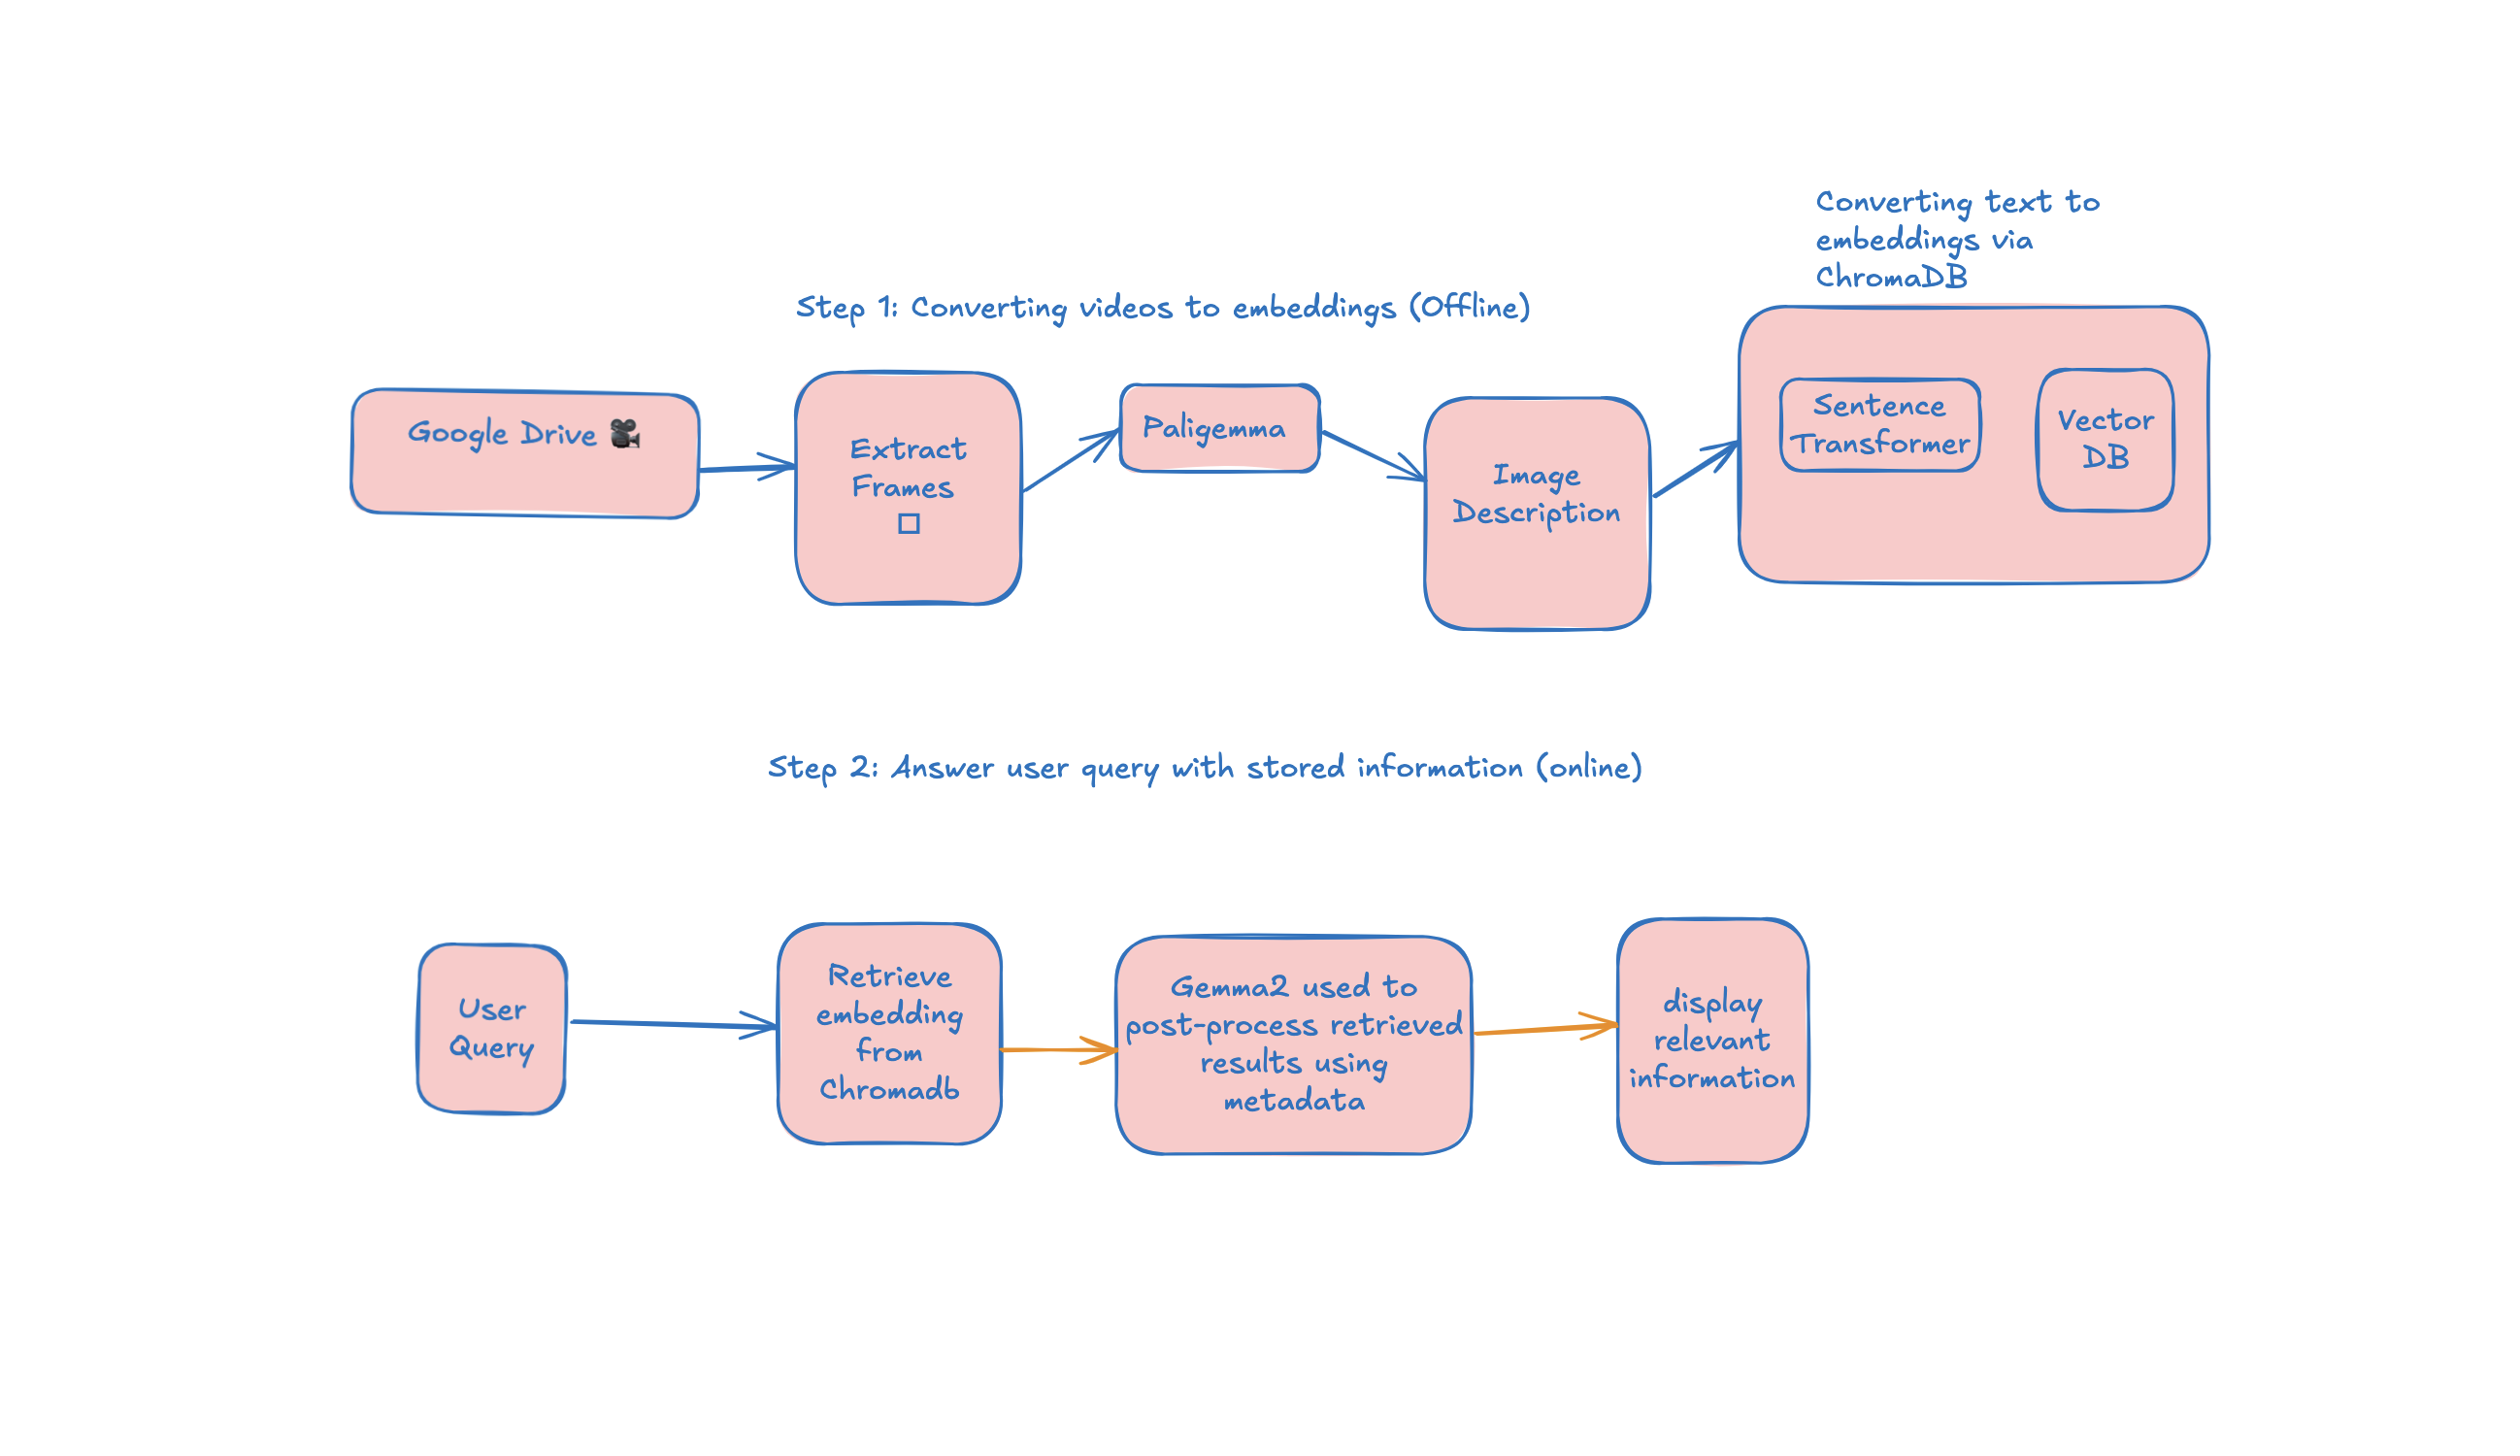

Why this:
1. **Computational efficiency**: Direct video processing by large models is extremely resource-intensive. This frame extraction approach significantly reduces computational costs.
2. **Latency considerations**: End-to-end video processing introduces higher latency, which is problematic for interactive applications. This pipeline allows for faster query responses.
3. **Retrieval precision**: This approach enables more targeted retrieval since you're working with discrete, meaningful frames rather than processing entire videos at query time.

In [1]:
!pip install -q -U accelerate bitsandbytes git+https://github.com/huggingface/transformers.git
! pip install opencv-python
! pip install hachoir
! pip install tiktoken
! pip install chromadb
! pip install sentence_transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install -Uq chromadb

PaliGemma requires users to accept Gemma license, so make sure to go to [the repository]() and ask for access. If you have previously accepted Gemma license, you will have access to this model as well. Once you have the access, login to Hugging Face Hub using `notebook_login()` and pass your access token by running the cell below.

In [3]:
from huggingface_hub import notebook_login

notebook_login()

## Step 1 : Extract Frames from Video along with Metadata

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import cv2
import os
import json
from datetime import datetime
from hachoir.metadata import extractMetadata
from hachoir.parser import createParser

def extract_frames_from_directory(input_dir, output_dir, frame_interval=1):
    """
    Extract frames from all .MOV and .mp4 video files in a directory.
    Saves frames as images and creates metadata for each video.

    Parameters:
        input_dir (str): Directory containing video files.
        output_dir (str): Directory where extracted images will be saved.
        frame_interval (int): Save every `frame_interval`-th frame (default is 1)
    """
    # Check if input directory exists
    if not os.path.exists(input_dir):
        print(f"Error: Input directory '{input_dir}' does not exist.")
        return

    # Check if output directory exists, create if not
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Supported video formats
    supported_formats = ['.mov', '.mp4']

    # Iterate over all files in the input directory
    for filename in os.listdir(input_dir):
        file_path = os.path.join(input_dir, filename)

        # Process only .MOV and .mp4 files
        if os.path.isfile(file_path) and os.path.splitext(filename)[1].lower() in supported_formats:
            # Extract frames from the video
            extract_frames(file_path, output_dir, frame_interval)

def extract_frames(video_path, output_dir, frame_interval=1):
    """
    Extract frames from a video file and save them as images.
    Also saves metadata about the video and extraction.

    Parameters:
        video_path (str): Path to the input video file.
        output_dir (str): Directory where extracted images will be saved.
        frame_interval (int): Save every `frame_interval`-th frame (default is 1).
    """
    # Capture the video
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Unable to open video file '{video_path}'.")
        return

    # Extract video name without extension for use in frame naming
    video_name = os.path.splitext(os.path.basename(video_path))[0]

    frame_count = 0
    saved_count = 0

    # Attempt to extract the metadata creation date if possible
    try:
        # Extract creation time from file metadata
        file_stats = os.stat(video_path)
        creation_time = datetime.fromtimestamp(file_stats.st_mtime).strftime("%Y-%m-%d %H:%M:%S")
    except Exception as e:
        print(f"Unable to extract creation date from the video file. Error: {e}")
        creation_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Initialize additional metadata values
    location = {}
    device_details = {}

    # Attempt to extract metadata using hachoir
    try:
        parser = createParser(video_path)
        if not parser:
            print(f"Unable to parse file '{video_path}'.")
        else:
            metadata = extractMetadata(parser)
            if metadata:
                for item in metadata.exportPlaintext():
                    # Extract location details
                    if "GPS" in item or "Latitude" in item or "Longitude" in item:
                        if "Latitude" in item:
                            location['latitude'] = item.split(": ")[1].strip()
                        elif "Longitude" in item:
                            location['longitude'] = item.split(": ")[1].strip()
                    # Extract device details
                    if "Make" in item or "Model" in item:
                        if "Make" in item:
                            device_details['make'] = item.split(": ")[1].strip()
                        elif "Model" in item:
                            device_details['model'] = item.split(": ")[1].strip()
    except Exception as e:
        print(f"Unable to extract additional metadata from the video file. Error: {e}")

    # Metadata dictionary to store video information
    video_metadata = {
        "video_path": video_path,
        "frame_interval": frame_interval,
        "frames_extracted": 0,
        "date_created": creation_time,
        "original_frame_count": int(cap.get(cv2.CAP_PROP_FRAME_COUNT)),
        "fps": cap.get(cv2.CAP_PROP_FPS),
        "frame_names": []  # To store names of extracted frames
    }

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Save frame only if it's the nth frame based on frame_interval
        if frame_count % frame_interval == 0:
            frame_filename = f"{video_name}_frame_{frame_count:04d}.jpg"
            frame_filepath = os.path.join(output_dir, frame_filename)
            cv2.imwrite(frame_filepath, frame)
            saved_count += 1
            video_metadata["frame_names"].append(frame_filename)

        frame_count += 1

    cap.release()

    # Update metadata with the number of frames saved
    video_metadata["frames_extracted"] = saved_count

    # Save metadata to JSON file
    metadata_filename = os.path.join(output_dir, f"{video_name}_metadata.json")
    with open(metadata_filename, "w") as metadata_file:
        json.dump(video_metadata, metadata_file, indent=4)

    print(f"Done! Extracted {saved_count} frames from '{video_path}' and saved them in '{output_dir}'.")
    print(f"Metadata saved as '{metadata_filename}'.")

In [6]:
input_folder = "/content/drive/MyDrive/Home_videos"  # Replace with your directory containing video files
output_folder = "/content/drive/MyDrive/Home_videos/frames"  # Replace with your desired output directory
extract_frames_from_directory(input_folder, output_folder, frame_interval=30)  # Extract every 30th frame from each video

Done! Extracted 9 frames from '/content/drive/MyDrive/Home_videos/PXL_20241130_153431655.mp4' and saved them in '/content/drive/MyDrive/Home_videos/frames'.
Metadata saved as '/content/drive/MyDrive/Home_videos/frames/PXL_20241130_153431655_metadata.json'.
Done! Extracted 23 frames from '/content/drive/MyDrive/Home_videos/PXL_20241130_153332633.mp4' and saved them in '/content/drive/MyDrive/Home_videos/frames'.
Metadata saved as '/content/drive/MyDrive/Home_videos/frames/PXL_20241130_153332633_metadata.json'.


## Step 2 : Generate Semantic Embedding of images using Gemma models

In [7]:
import torch
import numpy as np
from PIL import Image

You can load PaliGemma model and processor like below.

In [8]:
from transformers import AutoTokenizer, PaliGemmaForConditionalGeneration, PaliGemmaProcessor
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "google/paligemma-3b-mix-224"
paligemma_model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.bfloat16)
processor = PaliGemmaProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


The processor preprocesses both the image and text, so we will pass them.

In [9]:
# Testing the model and processor
input_text = "What is in this image?"
input_image = Image.open('/content/drive/MyDrive/Home_videos/frames/PXL_20241130_153332633_frame_0420.jpg')

In [10]:
inputs = processor(text=input_text, images=input_image,
                  padding="longest", do_convert_rgb=True, return_tensors="pt").to("cuda")
paligemma_model.to(device)
inputs = inputs.to(dtype=paligemma_model.dtype)

with torch.no_grad():
  output = paligemma_model.generate(**inputs, max_length=496)

print(processor.decode(output[0], skip_special_tokens=True))


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


What is in this image?
A person holds a pink pen in their hand, the pen being pink and the hand holding it also being pink. The floor is made of wood and the table is made of wood. The shelf is made of wood and has a bottle on it. The bottle is white and the cap is on the bottle. The cord is white and the wire is white. The pen is in the hand and the hand is holding the pen.


In [11]:
# read json file from output_folder
from pathlib import Path
import json
metadat_dict = {}
for json_path in Path(output_folder).glob('*json'):
  # Opening JSON file
  with open(json_path) as json_file:
      data = json.load(json_file)
      metadat_dict[json_path.stem] = data

In [12]:
import chromadb
try:
  client = chromadb.PersistentClient(path="/content/drive/MyDrive/Home_videos/chroma_db")
except:
  pass
settings = client.get_settings()
settings.allow_reset = True
collection = client.get_or_create_collection("object_in_videos")

In [13]:
from pathlib import Path
metadata = []
image_description_collection = []
for image_path in Path(output_folder).glob('*jpg'):
    input_image = Image.open(image_path)
    inputs = processor(text=input_text, images=input_image,
                  padding="longest", do_convert_rgb=True, return_tensors="pt").to("cuda")
    inputs = inputs.to(dtype=paligemma_model.dtype)
    try:
      with torch.no_grad():
        output = paligemma_model.generate(**inputs, max_length=496)
      image_description = processor.decode(output[0], skip_special_tokens=True)
      image_description_collection.append(image_description)
      video_prefix = '_'.join(image_path.stem.split('_')[:-2])
      video_metadata = metadat_dict[video_prefix+'_metadata']
      image_metadata = {}
      image_metadata['image_path'] = str(image_path)
      image_metadata['video_path'] = video_metadata['video_path']
      image_metadata['date_created'] = video_metadata['date_created']
      image_metadata['frame_id'] = int(image_path.stem.split('_')[-1])
      metadata.append(image_metadata)
    except Exception as e:
      print(f"Error processing image {image_path}: {e}")

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
Y

In [14]:
#By default, Chroma uses the Sentence Transformers all-MiniLM-L6-v2 model to create embeddings.
collection.add(documents=image_description_collection, metadatas=metadata,
 ids=[str(i) for i in range(len(image_description_collection))])


## Step 3 : Query Semantic Embedding of images

In [15]:
prompt_template = """
You are an assistive tool designed to answer questions with explanation and image_path of best match. Your task is to provide accurate
and relevant information based on the metadata and the description. Ensure your
answers are grounded in the provided metadata and the context of the last observed using the creation date and frame id .
return json with image_path and response.  i also want to use image path
User question: {}
Context:
{}
Video metadata:
{}

Answer:
"""



user_question = "what color is my gemma bag?"

results = collection.query(query_texts=user_question, n_results=5)

context = "\n".join(
    [f"{i+1}. {passage}" for i, passage in enumerate(results["documents"])]
)
last_observed= [(res['date_created'],res['frame_id'],res['image_path']) for res in results['metadatas'][0]]
prompt = f"{prompt_template.format(user_question, context, last_observed)}"

In [16]:
from transformers import AutoTokenizer
import transformers
import torch
import bitsandbytes, accelerate

model = "google/gemma-2-2b-it"

tokenizer = AutoTokenizer.from_pretrained(model)
pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    model_kwargs={
        "torch_dtype": torch.float16,
        "quantization_config": {"load_in_4bit": True},
    },
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py:463: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


The image shows a black bag with the word 'Gemma' on it.


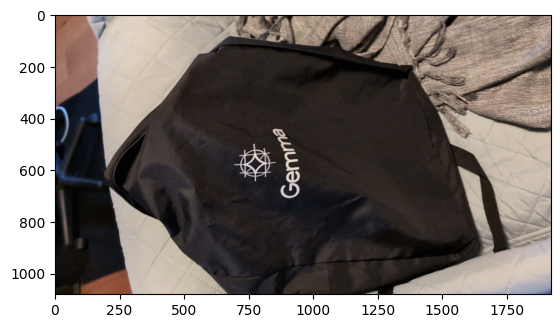

In [17]:

import matplotlib.pyplot as plt
import json
messages = [
    {"role": "user", "content": prompt},
]
prompt = pipeline.tokenizer.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
outputs = pipeline(prompt, max_new_tokens=256, do_sample=True, temperature=0.1)
json_string = json.loads(outputs[0]["generated_text"][len(prompt):][7:-5])
plt.imshow(plt.imread(json_string['image_path']))
print(json_string['response'])


# 🧠 Found It – Gen AI Evaluation Notes

This cell documents the evaluation results, observations, and reflections from the "Found it - Gemma Model Gen AI" project using Gemma and PaliGemma for AI-powered video search.

---

## 🔍 Evaluation Methodology

### Components Evaluated:
- **Input:** User Query (Text) + Input Image (from video)
- **Processing Pipeline:**
  - Frames extracted from video
  - Descriptions generated using **PaliGemma**
  - Embeddings created using **Sentence Transformer**
  - Stored in **Chroma DB**
- **Query Execution:**
  - Natural language input (e.g., *“Where is my key?”*)
  - Semantic similarity search in Chroma DB
- **Metric Used:** Cosine Similarity Score
- **Ground Truth:** Compared retrieved image/frame to expected object presence

---

## 📈 Accuracy Observations

| Example Query                |
|------------------------------|
| Where is the mirror?         |
| Where is the vacuum cleaner? |
| Where are the apples?        |
| Where is the stool?          |
| Where are the aples? (typo)  |
| Where is the coffee?         |

- **Overall Accuracy Range (PaliGemma):** ~50–80%
- **Failure Cases:** Low-resolution images, spelling errors, niche objects

---

## ⚠️ Known Challenges

- **Small/Niche Object Detection:** Often missed or poorly described by the model.
- **Text Preprocessing:** Misspellings drastically lower retrieval accuracy.
- **Memory Overhead:** High when processing long or noisy videos offline.

---

## ✅ What Worked Well

- **Offline Embedding Pipeline:** Ensures data privacy while supporting search capability.
- **ChromaDB + Sentence Transformers:** Effective for text-to-image matching.
- **Gemma & PaliGemma:** Lightweight, open-source, accessible for edge or local inference.
- **Scalable Design:** Split pipeline (offline processing + online querying) enables cloud or local deployment.

---



## 💡 Final Thoughts

This project showcases an impactful application of open-source GenAI tools for a socially relevant use case—supporting memory-impaired or elderly individuals in locating items.

Key takeaways:

- **Design Balance:** Lightweight architecture makes this practical for real-world scenarios, especially with privacy-sensitive populations.
- **Semantic Search:** Embedding-based retrieval provides natural interaction but still needs refinement.
- **Improvement Areas:**
  - Add spell correction to queries
  - Improve detection of small, non-obvious objects
  - Explore real-time video detection
  - Integrate temporal information

> With continued development, this system can evolve into a truly empowering assistive tech tool.

